In [1]:
import pandas as pd
from datetime import datetime
from IPython.display import display
import os
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/content/CSAW-CC_breast_cancer_screening_data.csv")
df = df.drop(
    columns=[
        "x_cancer_laterality",
        "x_type",
        "x_age",
        "x_lymphnode_met",
        "rad_recall",
        "rad_recall_type_left",
        "x_case",
        "rad_r1",
        "rad_r2",
        "rad_recall_type_right",
    ]
)
display(df)

,anon_patientid,exam_year,anon_filename,rad_timing,imagelaterality,viewposition,libra_breastarea,libra_densearea,libra_percentdensity
0,2,2015,00002_20990909_L_CC_1.dcm,2.0,Left,CC,127.258090,29.595217,23.256058
1,2,2015,00002_20990909_L_MLO_1.dcm,2.0,Left,MLO,122.318120,39.298000,32.127705
2,2,2015,00002_20990909_R_CC_1.dcm,2.0,Right,CC,114.570630,23.637600,20.631468
3,2,2015,00002_20990909_R_MLO_1.dcm,2.0,Right,MLO,133.202380,36.162785,27.148750
4,4,2012,00004_20990909_R_CC_1.dcm,NaN,Right,CC,201.187730,68.998276,34.295467
...,...,...,...,...,...,...,...,...,...
98783,11301,2015,11301_20990909_R_CC_1.dcm,NaN,Right,CC,69.278275,24.969255,36.041973
98784,11303,2014,11303_20990909_R_CC_1.dcm,1.0,Right,CC,196.125440,33.502670,17.082268
98785,11303,2014,11303_20990909_L_MLO_1.dcm,1.0,Left,MLO,257.890530,15.262912,5.918369
98786,11303,2014,11303_20990909_R_MLO_1.dcm,1.0,Right,MLO,232.718640,14.388752,6.182896


In [3]:
cancer_years = {}

# Step 1: Identify cancer year for each patient
cancer_years = {}
for patient_id, group in df.groupby("anon_patientid"):
    # Get the most recent exam year for this patient
    most_recent_exam = group.loc[group["exam_year"].idxmax()]

    rad_timing = most_recent_exam["rad_timing"]

    # Step 2: Calculate cancer year based on rad_timing
    if rad_timing == 1:  # Screen-detected cancer (within 60 days)
        cancer_years[patient_id] = most_recent_exam["exam_year"]
    elif rad_timing == 2:  # Interval cancer (60-729 days)
        # If the last exam year is 2013, set cancer year to 2015
        cancer_years[patient_id] = most_recent_exam["exam_year"] + 2
        if most_recent_exam["exam_year"] == 2015:
            cancer_years[patient_id] = 2016

# Step 3: Calculate years to cancer for each image
df["years_to_cancer"] = df.apply(
    lambda row: (
        cancer_years.get(row["anon_patientid"], None) - row["exam_year"]
        if row["anon_patientid"] in cancer_years
        else None
    ),
    axis=1,
)

# Step 4: Calculate years to last follow-up (based on the latest exam year for each patient)
latest_exam_years = df.groupby("anon_patientid")["exam_year"].max()
df["years_to_last_followup"] = df.apply(
    lambda row: (latest_exam_years[row["anon_patientid"]] - row["exam_year"]), axis=1
)

# Output the final DataFrame with calculated values

display(df)

,anon_patientid,exam_year,anon_filename,rad_timing,imagelaterality,viewposition,libra_breastarea,libra_densearea,libra_percentdensity,years_to_cancer,years_to_last_followup
0,2,2015,00002_20990909_L_CC_1.dcm,2.0,Left,CC,127.258090,29.595217,23.256058,1.0,0
1,2,2015,00002_20990909_L_MLO_1.dcm,2.0,Left,MLO,122.318120,39.298000,32.127705,1.0,0
2,2,2015,00002_20990909_R_CC_1.dcm,2.0,Right,CC,114.570630,23.637600,20.631468,1.0,0
3,2,2015,00002_20990909_R_MLO_1.dcm,2.0,Right,MLO,133.202380,36.162785,27.148750,1.0,0
4,4,2012,00004_20990909_R_CC_1.dcm,NaN,Right,CC,201.187730,68.998276,34.295467,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...
98783,11301,2015,11301_20990909_R_CC_1.dcm,NaN,Right,CC,69.278275,24.969255,36.041973,NaN,0
98784,11303,2014,11303_20990909_R_CC_1.dcm,1.0,Right,CC,196.125440,33.502670,17.082268,0.0,0
98785,11303,2014,11303_20990909_L_MLO_1.dcm,1.0,Left,MLO,257.890530,15.262912,5.918369,0.0,0
98786,11303,2014,11303_20990909_R_MLO_1.dcm,1.0,Right,MLO,232.718640,14.388752,6.182896,0.0,0


In [4]:
df_filtered = df.groupby("anon_patientid").filter(
    lambda x: x["exam_year"].nunique() > 1
)
df_filtered["years_to_cancer"] = df_filtered["years_to_cancer"].fillna(100)

In [23]:
# Step 1: Identify cancer-free patients with at least 5 years of follow-up
cancer_free_patients = df_filtered[df_filtered["years_to_cancer"] == 100]
follow_up_period = cancer_free_patients.groupby("anon_patientid")["exam_year"].agg(
    ["min", "max"]
)
follow_up_period["duration_years"] = follow_up_period["max"] - follow_up_period["min"]

# Select patients with at least 5 years of follow-up
patients_with_5_years = follow_up_period[follow_up_period["duration_years"] >= 5].index
# Step 2: Identify patients with years_to_cancer in [1, 2, 3, 4, 5]
cancer_patients = df_filtered[df_filtered["years_to_cancer"].isin([0, 1, 2, 3, 4, 5])][
    "anon_patientid"
].unique()

# Step 3: Combine both groups of patients
valid_patients = set(patients_with_5_years).union(set(cancer_patients))

# Step 4: Apply filtering to keep only the selected patients
df_filtered_new = df_filtered[
    df_filtered["anon_patientid"].isin(valid_patients)
].reset_index(drop=True)
csaw_cc_filtered = df_filtered_new[df_filtered_new["years_to_cancer"] <= 5]

# Display the filtered dataset
display(csaw_cc_filtered)

,anon_patientid,exam_year,anon_filename,rad_timing,imagelaterality,viewposition,libra_breastarea,libra_densearea,libra_percentdensity,years_to_cancer,years_to_last_followup
72,12,2010,00012_20990909_L_CC_4.dcm,3.0,Left,CC,136.76096,35.817825,26.190094,5.0,3
73,12,2010,00012_20990909_L_MLO_4.dcm,3.0,Left,MLO,174.23538,70.264435,40.327305,5.0,3
74,12,2010,00012_20990909_R_CC_4.dcm,3.0,Right,CC,124.90688,35.528526,28.444012,5.0,3
75,12,2010,00012_20990909_R_MLO_4.dcm,3.0,Right,MLO,152.16185,41.385010,27.198017,5.0,3
76,12,2012,00012_20990909_L_MLO_1.dcm,2.0,Left,MLO,180.70964,33.851551,18.732565,3.0,1
...,...,...,...,...,...,...,...,...,...,...,...
67679,11067,2008,11067_20990909_R_MLO_2.dcm,3.0,Right,MLO,252.23004,31.744160,12.585400,4.0,4
67680,11067,2012,11067_20990909_R_MLO_1.dcm,1.0,Right,MLO,223.90413,29.157743,13.022424,0.0,0
67681,11067,2012,11067_20990909_L_MLO_1.dcm,1.0,Left,MLO,261.45538,23.506672,8.990701,0.0,0
67682,11067,2012,11067_20990909_R_CC_1.dcm,1.0,Right,CC,223.48390,22.960224,10.273771,0.0,0


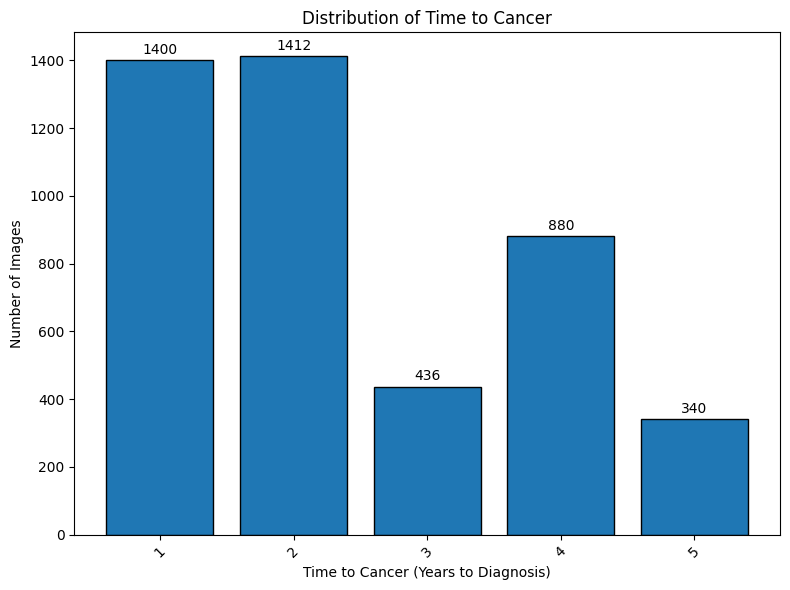

In [24]:
# csaw_cc_filtered.loc[csaw_cc_filtered['years_to_cancer'] == 0, 'years_to_cancer'] = 1

# Count the occurrences of each "years_to_cancer" value (2, 3, 4, 5)
counts = {
    1: len(csaw_cc_filtered[csaw_cc_filtered["years_to_cancer"] == 1])
    + len(csaw_cc_filtered[csaw_cc_filtered["years_to_cancer"] == 0]),
    2: len(csaw_cc_filtered[csaw_cc_filtered["years_to_cancer"] == 2]),
    3: len(csaw_cc_filtered[csaw_cc_filtered["years_to_cancer"] == 3]),
    4: len(csaw_cc_filtered[csaw_cc_filtered["years_to_cancer"] == 4]),
    5: len(csaw_cc_filtered[csaw_cc_filtered["years_to_cancer"] == 5]),
}

# Create a figure and axes for the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the bar chart with the counts for each year value (2Y, 3Y, 4Y, 5Y)
ax.bar(counts.keys(), counts.values(), edgecolor="black")

# Labeling the plot
ax.set_xlabel("Time to Cancer (Years to Diagnosis)")
ax.set_ylabel("Number of Images")
ax.set_title("Distribution of Time to Cancer")

# Add values above the bars
for i, value in enumerate(counts.values()):
    ax.text(
        list(counts.keys())[i],
        value + 10,
        str(value),
        ha="center",
        va="bottom",
        fontsize=10,
    )

# Rotate x-axis labels for better readability
ax.tick_params(axis="x", rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

In [25]:
csaw_cc_filtered = csaw_cc_filtered.rename(
    columns={
        "anon_patientid": "patient_id",
        "anon_filename": "file_name",
        "imagelaterality": "laterality",
    }
)
display(csaw_cc_filtered)

,patient_id,exam_year,file_name,rad_timing,laterality,viewposition,libra_breastarea,libra_densearea,libra_percentdensity,years_to_cancer,years_to_last_followup
72,12,2010,00012_20990909_L_CC_4.dcm,3.0,Left,CC,136.76096,35.817825,26.190094,5.0,3
73,12,2010,00012_20990909_L_MLO_4.dcm,3.0,Left,MLO,174.23538,70.264435,40.327305,5.0,3
74,12,2010,00012_20990909_R_CC_4.dcm,3.0,Right,CC,124.90688,35.528526,28.444012,5.0,3
75,12,2010,00012_20990909_R_MLO_4.dcm,3.0,Right,MLO,152.16185,41.385010,27.198017,5.0,3
76,12,2012,00012_20990909_L_MLO_1.dcm,2.0,Left,MLO,180.70964,33.851551,18.732565,3.0,1
...,...,...,...,...,...,...,...,...,...,...,...
67679,11067,2008,11067_20990909_R_MLO_2.dcm,3.0,Right,MLO,252.23004,31.744160,12.585400,4.0,4
67680,11067,2012,11067_20990909_R_MLO_1.dcm,1.0,Right,MLO,223.90413,29.157743,13.022424,0.0,0
67681,11067,2012,11067_20990909_L_MLO_1.dcm,1.0,Left,MLO,261.45538,23.506672,8.990701,0.0,0
67682,11067,2012,11067_20990909_R_CC_1.dcm,1.0,Right,CC,223.48390,22.960224,10.273771,0.0,0


In [26]:
csaw_cc_filtered["anon_dicom_path_local"] = (
    "/storage/csaw_cc_data_full/2021-204-1-1/data/" + csaw_cc_filtered["file_name"]
)
display(csaw_cc_filtered)

,patient_id,exam_year,file_name,rad_timing,laterality,viewposition,libra_breastarea,libra_densearea,libra_percentdensity,years_to_cancer,years_to_last_followup,anon_dicom_path_local
72,12,2010,00012_20990909_L_CC_4.dcm,3.0,Left,CC,136.76096,35.817825,26.190094,5.0,3,/storage/csaw_cc_data_full/2021-204-1-1/data/0...
73,12,2010,00012_20990909_L_MLO_4.dcm,3.0,Left,MLO,174.23538,70.264435,40.327305,5.0,3,/storage/csaw_cc_data_full/2021-204-1-1/data/0...
74,12,2010,00012_20990909_R_CC_4.dcm,3.0,Right,CC,124.90688,35.528526,28.444012,5.0,3,/storage/csaw_cc_data_full/2021-204-1-1/data/0...
75,12,2010,00012_20990909_R_MLO_4.dcm,3.0,Right,MLO,152.16185,41.385010,27.198017,5.0,3,/storage/csaw_cc_data_full/2021-204-1-1/data/0...
76,12,2012,00012_20990909_L_MLO_1.dcm,2.0,Left,MLO,180.70964,33.851551,18.732565,3.0,1,/storage/csaw_cc_data_full/2021-204-1-1/data/0...
...,...,...,...,...,...,...,...,...,...,...,...,...
67679,11067,2008,11067_20990909_R_MLO_2.dcm,3.0,Right,MLO,252.23004,31.744160,12.585400,4.0,4,/storage/csaw_cc_data_full/2021-204-1-1/data/1...
67680,11067,2012,11067_20990909_R_MLO_1.dcm,1.0,Right,MLO,223.90413,29.157743,13.022424,0.0,0,/storage/csaw_cc_data_full/2021-204-1-1/data/1...
67681,11067,2012,11067_20990909_L_MLO_1.dcm,1.0,Left,MLO,261.45538,23.506672,8.990701,0.0,0,/storage/csaw_cc_data_full/2021-204-1-1/data/1...
67682,11067,2012,11067_20990909_R_CC_1.dcm,1.0,Right,CC,223.48390,22.960224,10.273771,0.0,0,/storage/csaw_cc_data_full/2021-204-1-1/data/1...


In [27]:
csaw_cc_filtered["file_name"] = csaw_cc_filtered["file_name"].str.replace(
    ".dcm", ".png", regex=False
)
display(csaw_cc_filtered)

,patient_id,exam_year,file_name,rad_timing,laterality,viewposition,libra_breastarea,libra_densearea,libra_percentdensity,years_to_cancer,years_to_last_followup,anon_dicom_path_local
72,12,2010,00012_20990909_L_CC_4.png,3.0,Left,CC,136.76096,35.817825,26.190094,5.0,3,/storage/csaw_cc_data_full/2021-204-1-1/data/0...
73,12,2010,00012_20990909_L_MLO_4.png,3.0,Left,MLO,174.23538,70.264435,40.327305,5.0,3,/storage/csaw_cc_data_full/2021-204-1-1/data/0...
74,12,2010,00012_20990909_R_CC_4.png,3.0,Right,CC,124.90688,35.528526,28.444012,5.0,3,/storage/csaw_cc_data_full/2021-204-1-1/data/0...
75,12,2010,00012_20990909_R_MLO_4.png,3.0,Right,MLO,152.16185,41.385010,27.198017,5.0,3,/storage/csaw_cc_data_full/2021-204-1-1/data/0...
76,12,2012,00012_20990909_L_MLO_1.png,2.0,Left,MLO,180.70964,33.851551,18.732565,3.0,1,/storage/csaw_cc_data_full/2021-204-1-1/data/0...
...,...,...,...,...,...,...,...,...,...,...,...,...
67679,11067,2008,11067_20990909_R_MLO_2.png,3.0,Right,MLO,252.23004,31.744160,12.585400,4.0,4,/storage/csaw_cc_data_full/2021-204-1-1/data/1...
67680,11067,2012,11067_20990909_R_MLO_1.png,1.0,Right,MLO,223.90413,29.157743,13.022424,0.0,0,/storage/csaw_cc_data_full/2021-204-1-1/data/1...
67681,11067,2012,11067_20990909_L_MLO_1.png,1.0,Left,MLO,261.45538,23.506672,8.990701,0.0,0,/storage/csaw_cc_data_full/2021-204-1-1/data/1...
67682,11067,2012,11067_20990909_R_CC_1.png,1.0,Right,CC,223.48390,22.960224,10.273771,0.0,0,/storage/csaw_cc_data_full/2021-204-1-1/data/1...


In [28]:
from sklearn.model_selection import train_test_split

# Group the data by 'years_to_cancer'
grouped = csaw_cc_filtered.groupby("years_to_cancer")

# Empty lists to store splits

# First, we group the data by `patient_id` to ensure patients are only in one split
patients = csaw_cc_filtered["patient_id"].unique()

# Split the patients into train, validation, and test sets

train_patients, temp_patients = train_test_split(
    patients,
    test_size=0.5,
    stratify=csaw_cc_filtered.groupby("patient_id")["years_to_cancer"].first()[
        patients
    ],
)
val_patients, test_patients = train_test_split(
    temp_patients,
    test_size=0.6,
    stratify=csaw_cc_filtered.groupby("patient_id")["years_to_cancer"].first()[
        temp_patients
    ],
)

# Now, we can add the `split_group` to the original DataFrame based on patient assignment
csaw_cc_filtered["split_group"] = None
csaw_cc_filtered.loc[
    csaw_cc_filtered["patient_id"].isin(train_patients), "split_group"
] = "train"
csaw_cc_filtered.loc[
    csaw_cc_filtered["patient_id"].isin(val_patients), "split_group"
] = "val"
csaw_cc_filtered.loc[
    csaw_cc_filtered["patient_id"].isin(test_patients), "split_group"
] = "test"

# Verify that the `split_group` is properly assigned and the distribution of `years_to_cancer` is preserved
print(csaw_cc_filtered.groupby(["split_group", "years_to_cancer"]).size())

# Verify the distribution and the new 'split_group' column

split_group  years_to_cancer
test         0.0                340
             1.0                 52
             2.0                416
             3.0                124
             4.0                256
             5.0                100
train        0.0                632
             1.0                 88
             2.0                712
             3.0                224
             4.0                448
             5.0                172
val          0.0                248
             1.0                 40
             2.0                284
             3.0                 88
             4.0                176
             5.0                 68
dtype: int64


In [29]:
csaw_cc_filtered.to_csv("/content/metadata_csawcc_dcm_path.csv", index=False)

In [32]:
df2 = pd.read_csv("/content/metadata_csawcc_dcm_path_old.csv")
missing_filenames = csaw_cc_filtered[
    ~csaw_cc_filtered["file_name"].isin(df2["file_name"])
]

if missing_filenames.empty:
    print("All filenames from df1 are present in df2.")
else:
    print("Missing filenames:")
    print(missing_filenames)

Missing filenames:
       patient_id  exam_year                   file_name  rad_timing  \
672            73       2010   00073_20990909_R_CC_1.png         3.0   
673            73       2010  00073_20990909_R_MLO_1.png         3.0   
674            73       2010   00073_20990909_L_CC_1.png         3.0   
675            73       2010  00073_20990909_L_MLO_1.png         3.0   
676            73       2011  00073_20990909_R_MLO_2.png         2.0   
...           ...        ...                         ...         ...   
67627       10783       2010  10783_20990909_L_MLO_1.png         3.0   
67628       10783       2012  10783_20990909_R_MLO_2.png         2.0   
67629       10783       2012   10783_20990909_R_CC_2.png         2.0   
67630       10783       2012  10783_20990909_L_MLO_2.png         2.0   
67631       10783       2012   10783_20990909_L_CC_2.png         2.0   

      laterality viewposition  libra_breastarea  libra_densearea  \
672        Right           CC         129.49484 